In [19]:
import cv2
import zipfile
import numpy as np

data = {}
with zipfile.ZipFile("archive.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            data[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

In [20]:
def face_detection(img):
    face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    # The detectMultiScale() method is used to identify faces of different sizes in the input image.
    face = face_classifier.detectMultiScale(
    img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
    )
# finally, the minSize parameter sets the minimum size of the object to be detected.
# The model will ignore faces that are smaller than the minimum size specified.
    return face

In [21]:
def perform_pca(faces):
    # Convert the list of face images into a 2D array
    X = np.array(faces).reshape(len(faces), -1).astype(np.float64)

    # Compute the mean face and subtract it from each face image
    mean_face = np.mean(X, axis=0)
    X -= mean_face

    # Compute the covariance matrix of the face images
    cov = np.cov(X.T)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)

    # Sort the eigenvectors by eigenvalue in descending order
    sort_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sort_indices]
    eigvecs = eigvecs[:, sort_indices]

    # Project the face images onto the lower-dimensional space
    X_pca = np.dot(X, eigvecs)

    return mean_face, eigvecs, X_pca

def perform_pca_faster(faces):
    # Convert the list of face images into a 2D array
    X = np.array(faces).reshape(len(faces), -1).astype(np.float64)

    # Compute the mean face and subtract it from each face image
    mean_face = np.mean(X, axis=0)
    X -= mean_face

    # Compute the SVD of the centered face images
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Project the face images onto the lower-dimensional space
    X_pca = np.dot(X, Vt.T)

    return mean_face, Vt, X_pca


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def knn_recognition_model_grid_search(X_pca , labels):
    # Define the parameter grid to search over
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute']
    }

    # Create a k-NN classifier object
    knn = KNeighborsClassifier()

    # Create a GridSearchCV object to search over the parameter grid
    grid_search = GridSearchCV(knn, param_grid, cv=5)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_pca, labels)

    # Print the best hyperparameters found
    print("Best hyperparameters:", grid_search.best_params_)

    # Train a k-NN classifier using the best hyperparameters found
    best_knn = KNeighborsClassifier(**grid_search.best_params_)
    best_knn.fit(X_pca, labels)
    return best_knn

def knn_recognition_model(X_pca, labels):
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_pca, labels)
    return clf

In [23]:
# Extract faces from the data set
faces = []
labels = []
for filename, img in data.items():
    detected_faces = face_detection(img)
    for (x, y, w, h) in detected_faces:
        face_img = img[y:y+h, x:x+w]
        resized_face = cv2.resize(face_img, (100, 100))
        faces.append(resized_face)
        labels.append(filename.split("/")[0])

# Convert the list of faces to a numpy array
faces = np.array(faces)
print(labels)


['s1', 's1', 's1', 's1', 's1', 's1', 's10', 's10', 's10', 's10', 's10', 's10', 's10', 's10', 's10', 's11', 's11', 's11', 's11', 's11', 's11', 's11', 's11', 's11', 's11', 's12', 's12', 's12', 's12', 's12', 's12', 's12', 's12', 's12', 's12', 's13', 's13', 's13', 's13', 's13', 's13', 's13', 's13', 's13', 's14', 's14', 's14', 's14', 's14', 's14', 's14', 's14', 's14', 's14', 's15', 's15', 's15', 's15', 's15', 's15', 's15', 's15', 's15', 's16', 's16', 's16', 's16', 's16', 's16', 's16', 's17', 's17', 's17', 's17', 's17', 's17', 's17', 's17', 's18', 's18', 's18', 's18', 's18', 's18', 's18', 's18', 's18', 's18', 's19', 's19', 's19', 's19', 's19', 's19', 's19', 's2', 's2', 's2', 's2', 's2', 's2', 's2', 's2', 's20', 's20', 's20', 's20', 's20', 's20', 's20', 's20', 's20', 's20', 's21', 's21', 's21', 's21', 's21', 's21', 's21', 's21', 's21', 's21', 's22', 's22', 's22', 's22', 's22', 's22', 's22', 's22', 's22', 's22', 's23', 's23', 's23', 's23', 's23', 's23', 's23', 's23', 's23', 's23', 's24', 's24'

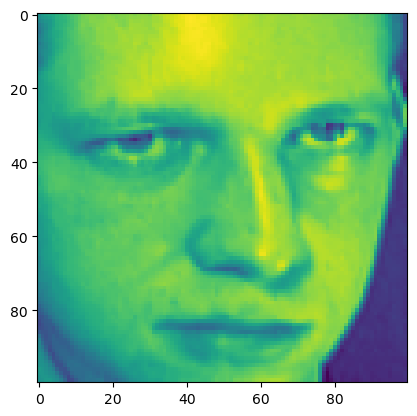

In [24]:
mean_face, eigvecs, X_pca = perform_pca_faster(faces)




plt.imshow(faces[1])

In [25]:
from sklearn.model_selection import train_test_split
train_X_pca, test_X_pca,train_labels, test_labels = train_test_split(list(X_pca), list(labels), test_size=0.2, random_state=42)

print(len(X_pca),len(labels))


348 348


In [31]:
knn_model = knn_recognition_model_grid_search(train_X_pca, train_labels)

y_pred = knn_model.predict(test_X_pca)

accuracy = knn_model.score(train_X_pca, train_labels)

print("Accuracy:", accuracy*100 , '%')

C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along

C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 100.0 %


C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def svm_recognition_model(X_train, y_train):
    # Define parameter grid to search over
    param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['linear', 'rbf']}

    # Create a SVM classifier
    svm_clf = SVC()

    # Use GridSearchCV to find the best hyperparameters
    svm_grid = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    svm_grid.fit(X_train, y_train)

    # Print the best hyperparameters and the best accuracy
    print("Best hyperparameters:", svm_grid.best_params_)
    print("Accuracy:", svm_grid.best_score_ *100 , '%')

    # Return the trained classifier
    return svm_grid.best_estimator_


In [28]:
from sklearn.decomposition import PCA

# Fit PCA on the training data
pca = PCA(n_components=100)
pca.fit(train_X_pca)

# Transform the test data using the fitted PCA object
transformed_test_X = pca.transform(test_X_pca)


In [30]:
svm_model = svm_recognition_model(test_X_pca, test_labels)

C:\Users\Mohamed Salman\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Accuracy: 64.28571428571429 %
